In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import intake
import xarray as xr
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import dask

In [3]:
from dask.distributed import Client
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 251.20 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:44991,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 251.20 GiB
Comm: tcp://127.0.0.1:34281,Total threads: 4
Dashboard: /proxy/39207/status,Memory: 35.89 GiB
Nanny: tcp://127.0.0.1:44999,


CPU times: user 17.7 s, sys: 2.06 s, total: 19.7 s
Wall time: 34.4 s


Text(0.5, 1.0, 'BRAN2020 current speed\n August climatology')

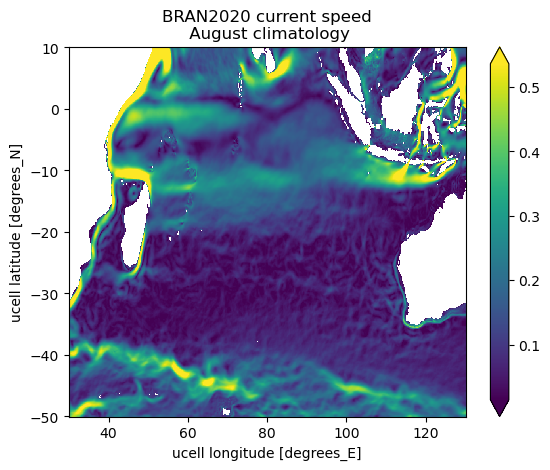

In [4]:
%%time
catalog_path = '/g/data/v14/tm4888/code/BRAN2020-intake-catalog/catalogs/'
BRAN2020_catalog = intake.open_esm_datastore(catalog_path+'BRAN2020.json', columns_with_iterables=['variable']) # load catalogue
search_uv_month = BRAN2020_catalog.search(variable=['u','v'],time_period='month') # search and filter data by variables and time period
DS = search_uv_month.to_dask() # load data lazily with Dask
DS_slice = DS.isel(st_ocean= 0).sel(xu_ocean=slice(30,130)).sel(yu_ocean=slice(-50,10)) # slice out reduced XYZ subset required
clim_uv = DS_slice.groupby('Time.month').mean(method="cohorts", engine="flox") ## calculate climatology & chunking rules everything!
speed = np.sqrt(clim_uv.u**2 + clim_uv.v**2) # calculate current speeds
speed.sel(month=8).plot(robust=True) #plot
plt.title('BRAN2020 current speed\n August climatology')

# compute uv climatology

In [ ]:
%%time
clim_uv = clim_uv.compute()

In [ ]:
%%time
speed = speed.compute()

# write out to scratch

In [ ]:
indian_BRAN2020_uv_speed = xr.merge([speed.rename('speed'),clim_uv])

In [ ]:
indian_BRAN2020_uv_speed

In [ ]:
%%time
indian_BRAN2020_uv_speed.to_netcdf('/scratch/xv83/tm4888/indian_BRAN2020/indian_BRAN2020_uv_speed.nc')

# read in from nc file

In [4]:
indian_BRAN2020_uv_speed_ = xr.open_dataset('/scratch/xv83/tm4888/indian_BRAN2020/indian_BRAN2020_uv_speed.nc')

In [5]:
indian_BRAN2020_uv_speed_

<xarray.Dataset>
Dimensions:   (xu_ocean: 1001, yu_ocean: 601, month: 12)
Coordinates:
  * xu_ocean  (xu_ocean) float64 30.0 30.1 30.2 30.3 ... 129.7 129.8 129.9 130.0
  * yu_ocean  (yu_ocean) float64 -50.0 -49.9 -49.8 -49.7 ... 9.7 9.8 9.9 10.0
    st_ocean  float64 ...
  * month     (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    speed     (month, yu_ocean, xu_ocean) float32 ...
    u         (month, yu_ocean, xu_ocean) float32 ...
    v         (month, yu_ocean, xu_ocean) float32 ...

In [6]:
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy
from matplotlib import mlab, cm, gridspec
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import cmocean
%matplotlib inline

In [7]:
def plot_currents_PlateCarree(central_longitude=0,figsize=(16,16),extent=[30, 130, -50, 10],
                    xticks=[30, 60,90, 120],yticks=[-50, -40,-30, -20,-10,0, 10],
                    xstride=10,ystride=10,my_plot_title='my_plot_title',plot_data=None,
                    x_data=None,y_data=None,u_data=None,v_data=None,cmap='Spectral_r',
                    cbar_kwargs = None,month_str=None,month_num=None,region_str=None,
                    **kwargs):
    """
    
    """
    long_list = np.arange(-180, 180, xstride)
    lat_list = np.arange(-90, 90, ystride)
                        
    proj = ccrs.PlateCarree(central_longitude=central_longitude)

    fig, ax = plt.subplots(subplot_kw=dict(projection=proj), figsize=figsize)
    #fig.canvas.draw()
    
    resolution='50m'
    land = cartopy.feature.NaturalEarthFeature('physical', 'land', \
        scale=resolution, edgecolor='k', facecolor=cfeature.COLORS['land'])
    ax.add_feature(land)


    gl = ax.gridlines(crs=proj, draw_labels=False, alpha=0.3, linewidth=0.5)
    gl.xlocator = mticker.FixedLocator(long_list)
    gl.ylocator = mticker.FixedLocator(lat_list)

    ax.set_xticks(xticks, crs=ccrs.PlateCarree())
    ax.set_yticks(yticks, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if plot_data is not None:
        ##### plotting #####
        plot_data.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs=cbar_kwargs, **kwargs, 
                                robust=True,cmap = cmap,add_colorbar=False)
    #plot u/v vectors
    ax.quiver(x_data.values,y_data.values,u_data.values,v_data.values,transform=ccrs.PlateCarree(), 
              units='x', width=0.01, scale=0.7, headwidth=5,alpha=0.2)
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    # Hide the axis label
    ax.set_ylabel('')
    ax.set_xlabel('')
    plt.title(my_plot_title)
    #plt.show()
    plot_DIR = '/scratch/xv83/tm4888/indian_BRAN2020/plots/'
    plot_file_name = 'indian_BRAN2020_'+str(month_num)+'_'+region_str+'.png'
    plot_path = plot_DIR + plot_file_name
    plt.savefig(plot_path, dpi = 600, bbox_inches='tight')
    plt.close(fig)

In [ ]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_indian = [30,130,-50,10]
regions = ['Indian_Ocean']
extent_dict = {'Indian_Ocean':extent_indian}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [9]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_madagascar = [40,70,-30,0]
regions = ['Madagascar']
extent_dict = {'Madagascar':extent_madagascar}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [11]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_maldives = [70,110,-10,10]
regions = ['Maldives']
extent_dict = {'Maldives':extent_maldives}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [13]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_indo = [95,130,-15,10]
regions = ['Indo']
extent_dict = {'Indo':extent_indo}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [10]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_wa = [100,120,-40,-20]
regions = ['WA']
extent_dict = {'WA':extent_wa}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [8]:
month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
extent_indo = [95,130,-15,10]
extent_wa = [100,120,-40,20]
regions = ['Indo','WA']
extent_dict = {'Indo':extent_indo,'WA':extent_wa}
# Define the x and y coordinates
x = indian_BRAN2020_uv_speed_.xu_ocean
y = indian_BRAN2020_uv_speed_.yu_ocean

In [11]:
%%time
for region_str in regions:
    region_extent = extent_dict[region_str]
    for time_choice in range(1,13):
        u = indian_BRAN2020_uv_speed_.u.sel(month=time_choice)
        v = indian_BRAN2020_uv_speed_.v.sel(month=time_choice)
        speed = indian_BRAN2020_uv_speed_.speed.sel(month=time_choice)
        month_str = month_list[time_choice-1]
        plot_currents_PlateCarree(plot_data=speed,x_data=x,y_data=y,u_data=u,v_data=v,
                                  extent=region_extent,levels=75,month_str=month_str,
                                  month_num=time_choice,region_str=region_str,
                                  my_plot_title='BRAN2020 reanalysis\n surface currents\n'+month_str+' climatology')

CPU times: user 3min 46s, sys: 15.9 s, total: 4min 2s
Wall time: 3min 51s
